# Wildfire Analysis in the US

By Leah Morgenstern

To get started, we have to import modules that will help us with our analysis. 'sqlite3' helps us connect the data from the sqlite file, pandas also helps to read in this data. the rest assist with our visualization.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

Next we are going to connect to our data so we can use it in our analysis.

In [2]:
# create db connection
conn = sqlite3.connect("C:/BootcampGIS/Data/data.sqlite")

# pull the fires table into RAM
fires = pd.read_sql_query("SELECT * FROM Fires", conn)

# check size
print(fires.memory_usage(index=True).sum() / (1024**2), 'Mb')

# disconnect from db
conn.close()

The following isn't completely necessary but helps us to get a glipse at what the data looks like, and what the column titles are which is useful later.

In [6]:
# glimpse at data
print(fires.head())

   OBJECTID                                              Shape  FOD_ID  \
0         1  b'\x00\x01\xad\x10\x00\x00\xc8\xce\n[_@^\xc0\x...       1   
1         2  b'\x00\x01\xad\x10\x00\x00\xc8\xe594\xe2\x19^\...       2   
2         3  b'\x00\x01\xad\x10\x00\x00x{\xac \x13/^\xc0@\x...       3   
3         4  b'\x00\x01\xad\x10\x00\x00\xc8\x13u\xd7s\xfa]\...       4   
4         5  b'\x00\x01\xad\x10\x00\x00\xd0\x11y\xf8\xb6\xf...       5   

       FPA_ID SOURCE_SYSTEM_TYPE SOURCE_SYSTEM NWCG_REPORTING_AGENCY  \
0  FS-1418826                FED   FS-FIRESTAT                    FS   
1  FS-1418827                FED   FS-FIRESTAT                    FS   
2  FS-1418835                FED   FS-FIRESTAT                    FS   
3  FS-1418845                FED   FS-FIRESTAT                    FS   
4  FS-1418847                FED   FS-FIRESTAT                    FS   

  NWCG_REPORTING_UNIT_ID  NWCG_REPORTING_UNIT_NAME SOURCE_REPORTING_UNIT  ...  \
0                USCAPNF    Plumas Nation

# Wildfires over Time

Our first plot is simply going to look at the number of wildfires that have occured in the US every year, from 1992 until 2020.

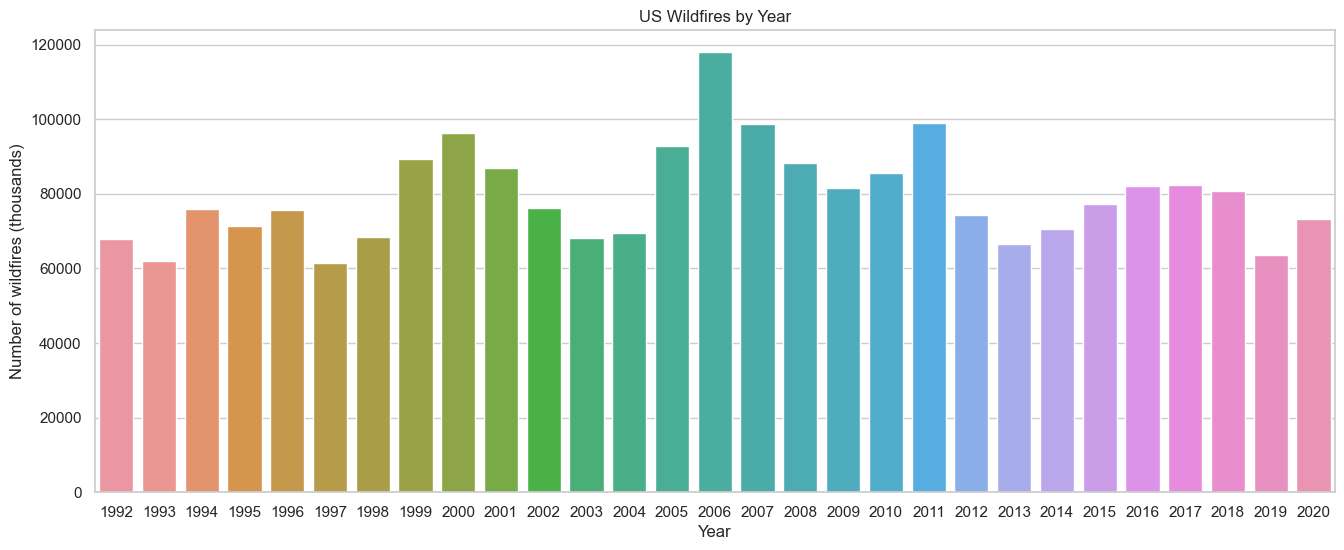

In [7]:
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
sns.barplot(x="FIRE_YEAR", y="n_fires", data=fires.groupby('FIRE_YEAR').size().reset_index(name='n_fires'))
plt.xlabel('Year')
plt.ylabel('Number of wildfires (thousands)')
plt.title('US Wildfires by Year')
plt.show()

The number of wildfires in the US ranges from approx. 60,000 - 100,000 per year, with a notable spike in 2006, reaching nearly 120,000.

# Causes

Next we will look at the various causes of wildfires in the US and number of fires each cause is responsible for.

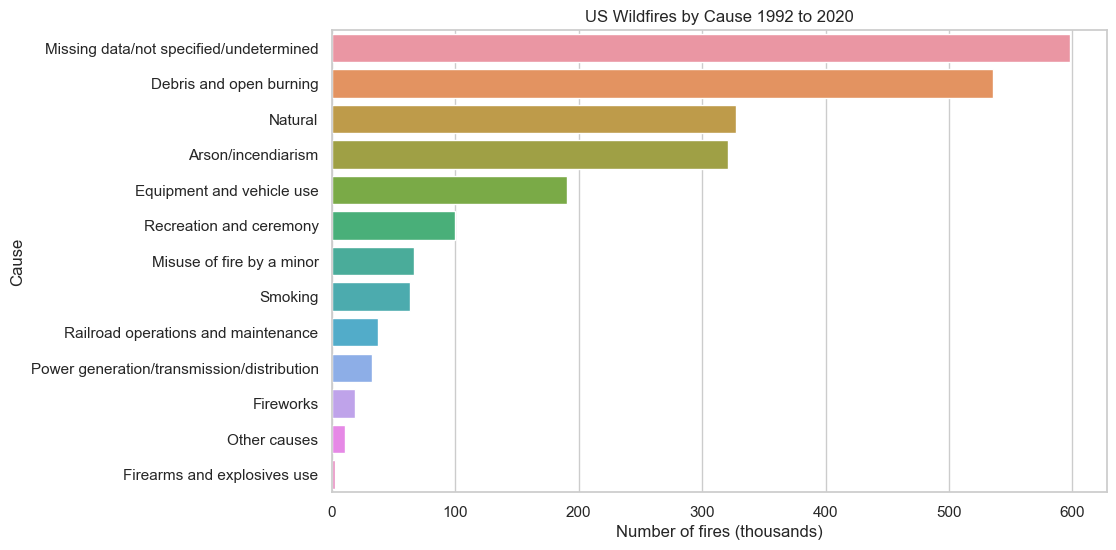

In [8]:
# Group by cause and calculate the number of fires
fires_cause = fires.groupby('NWCG_GENERAL_CAUSE').size().reset_index(name='n_fires')
fires_cause['n_fires'] /= 1000  # Convert to thousands

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(y="NWCG_GENERAL_CAUSE", x="n_fires", data=fires_cause.sort_values(by='n_fires', ascending=False))
plt.xlabel('Number of fires (thousands)')
plt.ylabel('Cause')
plt.title('US Wildfires by Cause 1992 to 2020')
plt.show()

The fact that the top cause is listed as "Missing data/not specified/undertermined" raises questions about the reliability of the data source and the methods used for data collection. However, it remains the most recent and up-to-date dataset available.

The next plot is similar to the previous one, but instead looks at the causes and the size of the wildfires rather than the number of fires.

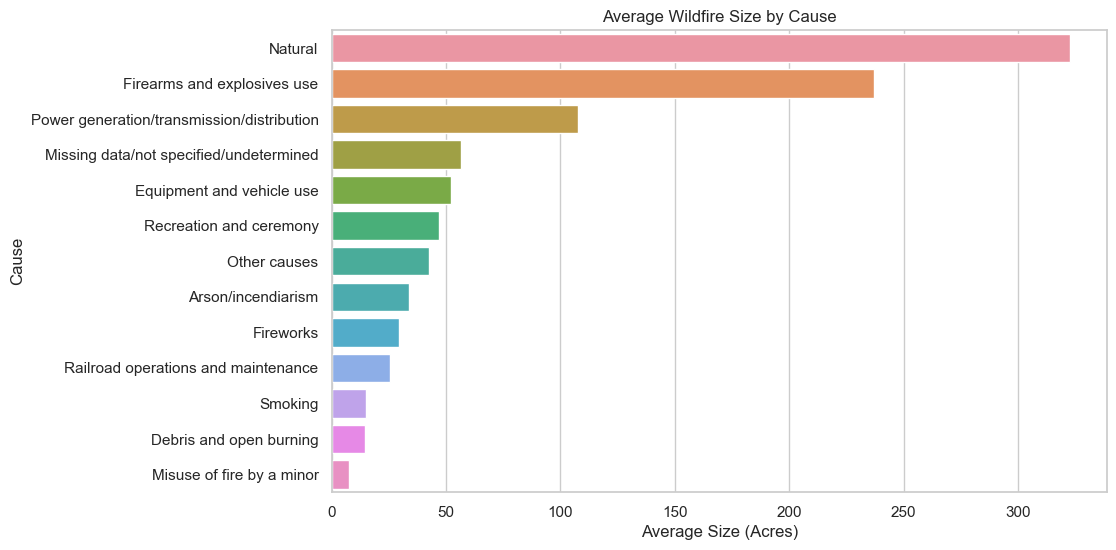

In [9]:
# Group by cause and calculate the mean size of fires
fires_cause_mean_size = fires.groupby('NWCG_GENERAL_CAUSE')['FIRE_SIZE'].mean().reset_index(name='mean_size')

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.barplot(y="NWCG_GENERAL_CAUSE", x="mean_size", data=fires_cause_mean_size.sort_values(by='mean_size', ascending=False))
plt.xlabel('Average Size (Acres)')
plt.ylabel('Cause')
plt.title('Average Wildfire Size by Cause')
plt.show()

This outcome is particularly noteworthy, suggesting that the largest fires are occurring naturally. With this conclusion, our priorities may need to shift more toward response rather than prevention.

# Wildfire Geography

Next, we will create a map of the US to see where the most wildfires have occured over the past 28 years.

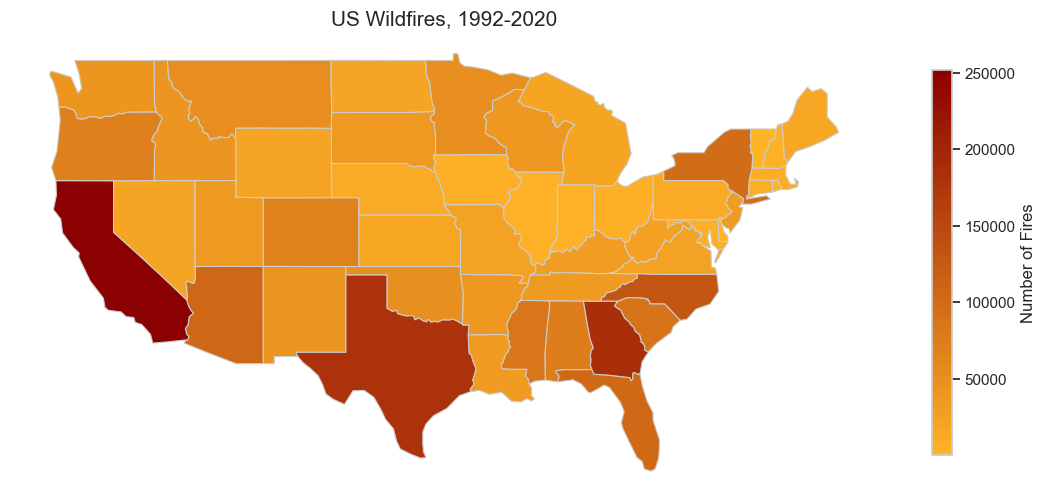

In [11]:
# Add codes for DC and Puerto Rico to the default state lists
state_abb = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
state_name = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

state_abb.extend(["DC", "PR"])
state_name.extend(["District of Columbia", "Puerto Rico"])

# Map the state abbreviations to state names so we can join with the map data
fires['region'] = fires['STATE'].map(lambda x: state_name[state_abb.index(x.upper())])

# Read the US states map data
us_states = gpd.read_file("C:/BootcampGIS/Data/110m_cultural/ne_110m_admin_1_states_provinces.shp")
us_states = us_states[us_states['name'].isin(state_name)]

# Filter out Alaska and Hawaii
excluded_states = ['Alaska', 'Hawaii']
us_states = us_states[~us_states['name'].isin(excluded_states)]

# Merge fires data with US states map data
merged_data = us_states.merge(fires.groupby('region').size().reset_index(name='n'), left_on='name', right_on='region', how='right')

# Create a custom colormap
from matplotlib.colors import LinearSegmentedColormap
colors = [(1.0, 0.7, 0.15), 'darkred']
cmap = LinearSegmentedColormap.from_list('custom', colors)

# Plot
fig, ax = plt.subplots(figsize=(14, 10))  # Adjust the figsize here
merged_data.plot(column='n', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, legend_kwds={'label': 'Number of Fires', 'orientation': 'vertical', 'shrink': 0.5})  # Adjust shrink parameter to make the legend smaller
ax.axis('off')
ax.set_title('US Wildfires, 1992-2020', fontdict={'fontsize': '15', 'fontweight' : '3'})
plt.show()

The top three states with the highest number of fires in the past 28 years are California, Texas, and Georgia. Given their size and climate, the first two are expected. However, Georgia's inclusion is rather surprising. Let's take a closer look at each of these three states.

# California

In this plot we will be comparing the wildfires in California by county with the population by county to see if there is any correlation.

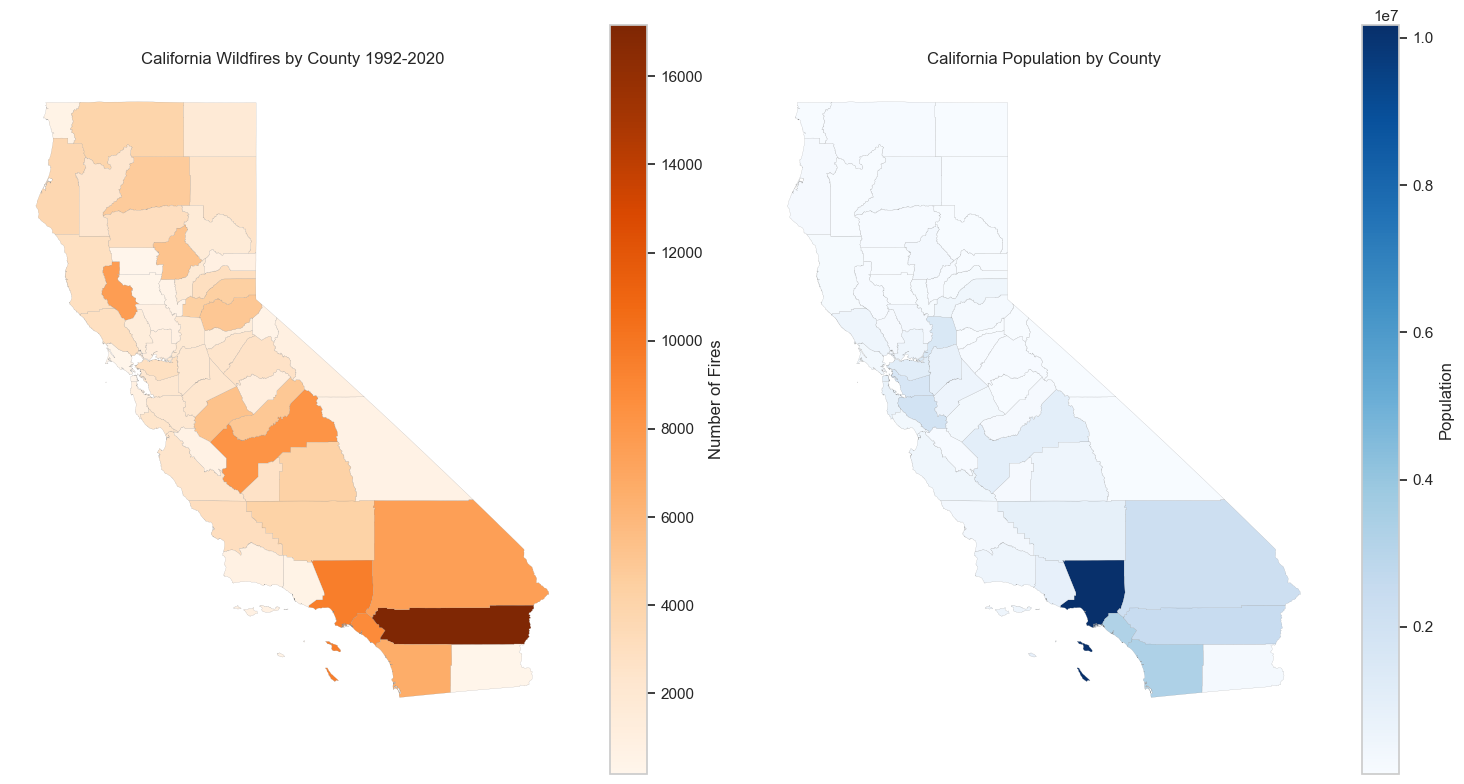

In [19]:
# Load county map data with population included
counties = gpd.read_file("C:/BootcampGIS/Data/Counties/USA_Counties.shp")

# Filter counties to only include California
california_counties = counties[counties['STATE_NAME'] == 'California']

# Group fires by county
fires_grouped = fires.groupby('FIPS_NAME')['FIRE_SIZE'].count().reset_index(name='n_fires')

# Merge fire count data with California county map data based on county names
merged_data_fires = california_counties.merge(fires_grouped, left_on='NAME', right_on='FIPS_NAME', how='left')

# Plot wildfires
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot wildfires
merged_data_fires.plot(column='n_fires', cmap='Oranges', linewidth=0.1, ax=axes[0], edgecolor='grey', legend=True, legend_kwds={'label': 'Number of Fires'})
axes[0].set_title('California Wildfires by County 1992-2020')
axes[0].axis('off')

# Plot population
california_counties.plot(column='POPULATION', cmap='Blues', linewidth=0.1, ax=axes[1], edgecolor='grey', legend=True, legend_kwds={'label': 'Population'})
axes[1].set_title('California Population by County')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Here we can see a lot of California's wildfires are concetrated more towards the south, and the highest populated area (Los Angeles) is adjacent to them. However, there are a few other areas with elevated fire occurances towards the north that have no connection to higher populations.

# Texas

Next, we will look at Texas.

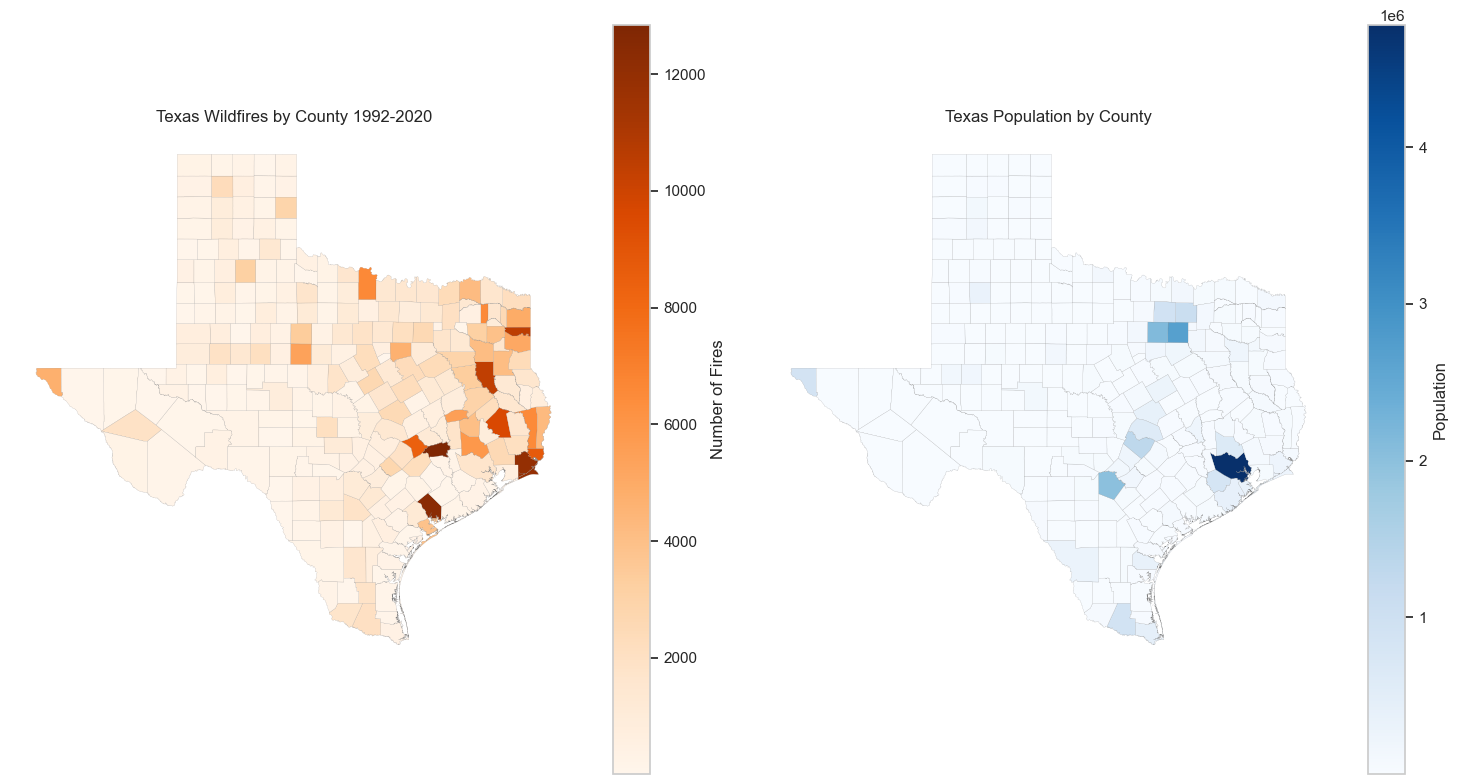

In [21]:
# Load county map data with population included
counties = gpd.read_file("C:/BootcampGIS/Data/Counties/USA_Counties.shp")

# Filter counties to only include Texas
Texas_counties = counties[counties['STATE_NAME'] == 'Texas']

# Group fires by county
fires_grouped = fires.groupby('FIPS_NAME')['FIRE_SIZE'].count().reset_index(name='n_fires')

# Merge fire count data with Texas county map data based on county names
merged_data_fires = Texas_counties.merge(fires_grouped, left_on='NAME', right_on='FIPS_NAME', how='left')

# Plot wildfires
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot wildfires
merged_data_fires.plot(column='n_fires', cmap='Oranges', linewidth=0.1, ax=axes[0], edgecolor='grey', legend=True, legend_kwds={'label': 'Number of Fires'})
axes[0].set_title('Texas Wildfires by County 1992-2020')
axes[0].axis('off')

# Plot population
Texas_counties.plot(column='POPULATION', cmap='Blues', linewidth=0.1, ax=axes[1], edgecolor='grey', legend=True, legend_kwds={'label': 'Population'})
axes[1].set_title('Texas Population by County')
axes[1].axis('off')

plt.tight_layout()
plt.show()

This display shows the highest population densities around major cities (Houston, Dallas), and highest wildfire occurances in counties surrounding these majorly populated areas.

# Georgia

Finally, we will look at Georgia.

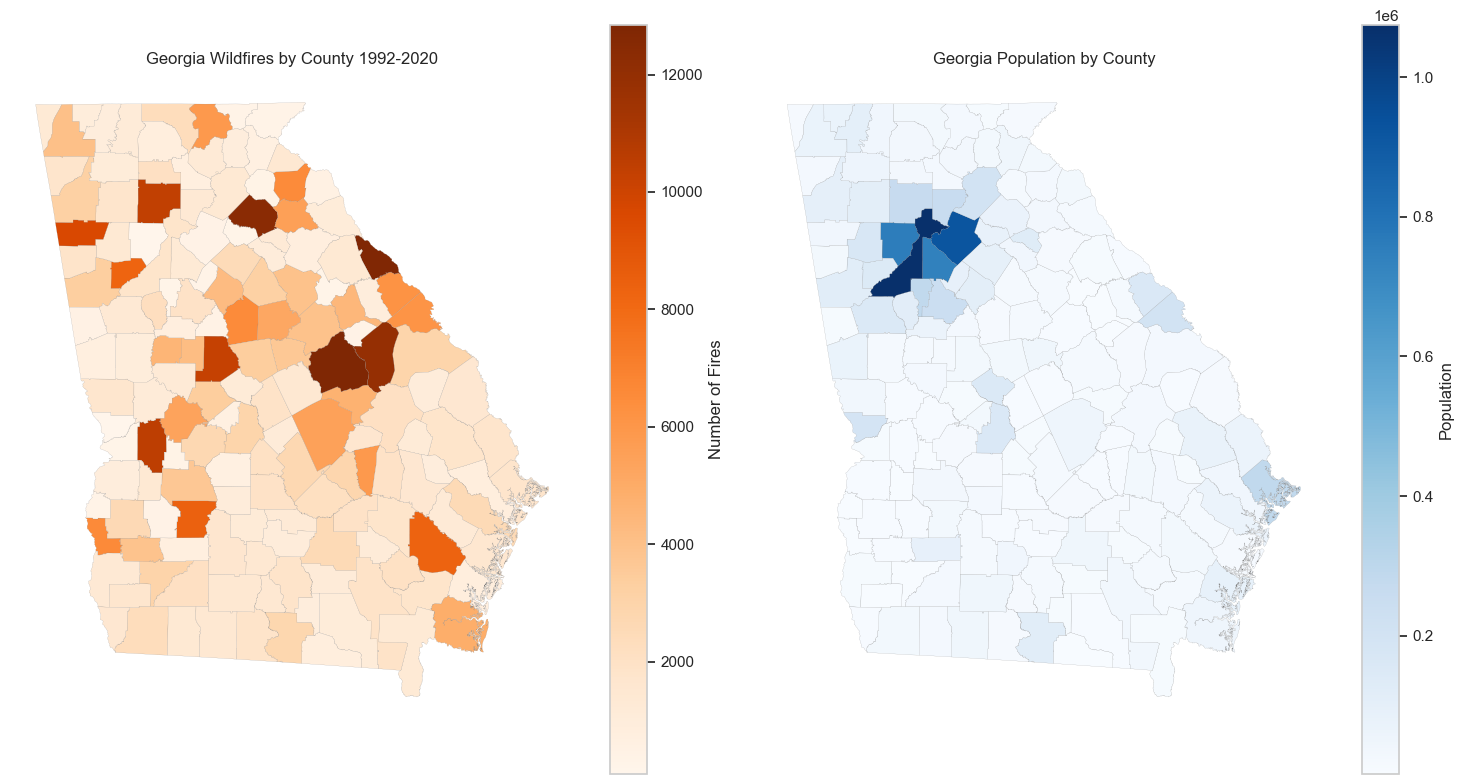

In [22]:
# Load county map data with population included
counties = gpd.read_file("C:/BootcampGIS/Data/Counties/USA_Counties.shp")

# Filter counties to only include Georgia
Georgia_counties = counties[counties['STATE_NAME'] == 'Georgia']

# Group fires by county
fires_grouped = fires.groupby('FIPS_NAME')['FIRE_SIZE'].count().reset_index(name='n_fires')

# Merge fire count data with Georgia county map data based on county names
merged_data_fires = Georgia_counties.merge(fires_grouped, left_on='NAME', right_on='FIPS_NAME', how='left')

# Plot wildfires
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Plot wildfires
merged_data_fires.plot(column='n_fires', cmap='Oranges', linewidth=0.1, ax=axes[0], edgecolor='grey', legend=True, legend_kwds={'label': 'Number of Fires'})
axes[0].set_title('Georgia Wildfires by County 1992-2020')
axes[0].axis('off')

# Plot population
Georgia_counties.plot(column='POPULATION', cmap='Blues', linewidth=0.1, ax=axes[1], edgecolor='grey', legend=True, legend_kwds={'label': 'Population'})
axes[1].set_title('Georgia Population by County')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In this display we see the wildfires are a bit more spread out throughout the state of Georgia whereas the population is more condensed to one area (around Atlanta). Thus there isn't as much correlation between the amount of wildfires and the population.

It is unsurprising to see population clusters around the major cities of these states. It is intriguing though to see the difference in the wildfire patterns within each state, and how higher numbers of people may be affected by them in one place, and less people are affected in another.